In [1]:
from collections import defaultdict
from pathlib import Path

import gurobipy as gp
import polars as pl
from gurobipy import GRB


In [2]:
def get_data(data_dir: str, discount_factor: int = 5):
    df = pl.read_csv(
        Path(f"{data_dir}/alternatives.csv"), schema_overrides={"unit": pl.Int64}, infer_schema_length=1000
    )
    df = df.select(
        [
            "unit",
            "schedule",
            f"npv_{discount_factor}_percent",
            "stock_0",
            "stock_5",
            "stock_25",
            "harvest_value_5",
            "harvest_value_25",
            "stock_1_0",
            "stock_1_5",
            "stock_1_25",
            "stock_2_0",
            "stock_2_5",
            "stock_2_25",
            "stock_30_0",
            "stock_30_5",
            "stock_30_25",
        ]
    )
    df_keys = pl.read_csv(
        Path(f"{data_dir}/alternatives_key.csv"), schema_overrides={"unit": pl.Int64}, infer_schema_length=1000
    )
    df_keys = df_keys.drop("holding")
    # Split the treatments into multiple columns, to make them easier to read or whatever
    df_keys = df_keys.with_columns(
        [
            pl.when(pl.col("treatment").str.contains("_5"))
            .then(pl.col("treatment").str.extract(r"(\w+)_5", 1))
            .otherwise(pl.lit("donothing"))
            .alias("treatment_5"),
            pl.when(pl.col("treatment").str.contains("_25"))
            .then(pl.col("treatment").str.extract(r"(\w+)_25", 1))
            .otherwise(pl.lit("donothing"))
            .alias("treatment_25"),
        ]
    )

    df = df_keys.join(df, on=["unit", "schedule"], how="inner")
    return df


def get_scenario_data(data_dir: str):
    return pl.read_csv(Path(f"{data_dir}/scenario.csv"), schema_overrides={"unit": pl.Int64}, infer_schema_length=1000)

In [ ]:
def tsrmop_asf(reference: dict):
    """This is the robust two stage model."""
    model = gp.Model()

    discount_factor = 5
    data_dirs = [
        "C:/MyTemp/data/two_stage_data/h1h23",
        "C:/MyTemp/data/two_stage_data/h1l23",
        "C:/MyTemp/data/two_stage_data/l1h23",
        "C:/MyTemp/data/two_stage_data/l1l23",
    ]
    n_scenarios = len(data_dirs)

    ideals = {
        "harvest5": 83939.39118553553,
        "harvest25": 411759.14052947034,
        "stock": 5873.921885563734,
        "npv": 306749.0841518348,
    }
    nadirs = {"harvest5": 0, "harvest25": 0, "stock": 256.86985522479296, "npv": 52867.07485820625}

    rho = 1e-6
    alpha = model.addVar(lb=-float("inf"))
    normalsum = 0
    hsum5 = []
    hsum25 = []
    npvsum = []
    stocksum = []
    mvars = []
    unitsums = []
    harvest5 = []
    harvest25 = []
    stock = []
    npv = []
    x0_vars = {}
    x0_unit_sum = defaultdict(float)

    for i in range(n_scenarios):
        hsum5.append(0)
        hsum25.append(0)
        npvsum.append(0)
        stocksum.append(0)
        mvars.append({})
        unitsums.append(defaultdict(float))

        # df = get_data(data_dirs[i], discount_factor=discount_factor)
        df = get_scenario_data(data_dirs[i])

        for row in df.iter_rows(named=True):
            if (row["unit"], row["treatment_5"]) not in x0_vars:
                x0_vars[(row["unit"], row["treatment_5"])] = model.addVar(vtype=GRB.BINARY)
                x0_unit_sum[row["unit"]] += x0_vars[(row["unit"], row["treatment_5"])]
            new_var = model.addVar(vtype=GRB.BINARY)
            mvars[i][(row["unit"], row["treatment_5"], row["treatment_25"])] = new_var
            hsum5[i] += new_var * row["harvest_value_5"]
            hsum25[i] += new_var * row["harvest_value_25"]
            npvsum[i] += new_var * row[f"npv_{discount_factor}_percent"]
            stocksum[i] += new_var * row["stock_25"]
            unitsums[i][(row["unit"], row["treatment_5"])] += new_var

        for key in unitsums[i]:
            model.addConstr(unitsums[i][key] == x0_vars[key])

        harvest5.append(model.addVar())
        model.addConstr(harvest5[i] == hsum5[i])
        harvest25.append(model.addVar())
        model.addConstr(harvest25[i] == hsum25[i])
        stock.append(model.addVar())
        model.addConstr(stock[i] == stocksum[i])
        npv.append(model.addVar())
        model.addConstr(npv[i] == npvsum[i])

        objectives = {"harvest5": harvest5[i], "harvest25": harvest25[i], "stock": stock[i], "npv": npv[i]}

        normalsum = 0
        for obj in objectives:
            normalsum += objectives[obj] / (nadirs[obj] - ideals[obj])

        for obj in objectives:
            model.addConstr(alpha >= (objectives[obj] - reference[obj]) / (nadirs[obj] - ideals[obj]) + rho * normalsum)
            ##normalsum += objectives[obj] / (nadirs[obj] - ideals[obj])
        # model.addConstr(alpha >= -npv[i] + rho*normalsum)

    for unitsum in x0_unit_sum.values():
        model.addConstr(unitsum == 1)

    # model.setObjective(alpha + rho * normalsum, sense=GRB.MINIMIZE)
    model.setObjective(alpha, sense=GRB.MINIMIZE)
    model.optimize()
    return (model, harvest5, harvest25, stock, npv, alpha)


In [ ]:
def rmop_asf(reference: dict):
    """This is the robust single stage model."""
    model = gp.Model()

    discount_factor = 5
    data_dirs = [
        "C:/MyTemp/data/two_stage_data/h1h23",
        "C:/MyTemp/data/two_stage_data/h1l23",
        "C:/MyTemp/data/two_stage_data/l1h23",
        "C:/MyTemp/data/two_stage_data/l1l23",
    ]
    n_scenarios = len(data_dirs)

    ideals = {
        "harvest5": 83939.39118553553,
        "harvest25": 411759.14052947034,
        "stock": 5873.921885563734,
        "npv": 306749.0841518348,
    }
    nadirs = {"harvest5": 0, "harvest25": 0, "stock": 256.86985522479296, "npv": 52867.07485820625}

    rho = 1e-6
    alpha = model.addVar(lb=-float("inf"))
    normalsum = 0
    hsum5 = []
    hsum25 = []
    npvsum = []
    stocksum = []
    mvars = []
    unitsums = []
    harvest5 = []
    harvest25 = []
    stock = []
    npv = []
    x0_vars = {}
    x0_unit_sum = defaultdict(float)

    for i in range(n_scenarios):
        hsum5.append(0)
        hsum25.append(0)
        npvsum.append(0)
        stocksum.append(0)
        mvars.append({})
        unitsums.append(defaultdict(float))

        # df = get_data(data_dirs[i], discount_factor=discount_factor)
        df = get_scenario_data(data_dirs[i])

        for row in df.iter_rows(named=True):
            #if (row["unit"], row["treatment_5"]) not in x0_vars:
            #    x0_vars[(row["unit"], row["treatment_5"])] = model.addVar(vtype=GRB.BINARY)
            #    x0_unit_sum[row["unit"]] += x0_vars[(row["unit"], row["treatment_5"])]
            if (row["unit"], row["treatment"]) not in x0_vars:
                x0_vars[(row["unit"], row["treatment"])] = model.addVar(vtype=GRB.BINARY)
                x0_unit_sum[row["unit"]] += x0_vars[(row["unit"], row["treatment"])]
            new_var = x0_vars[(row["unit"], row["treatment"])]
            mvars[i][(row["unit"], row["treatment_5"], row["treatment_25"])] = new_var
            hsum5[i] += new_var * row["harvest_value_5"]
            hsum25[i] += new_var * row["harvest_value_25"]
            npvsum[i] += new_var * row[f"npv_{discount_factor}_percent"]
            stocksum[i] += new_var * row["stock_25"]
            #unitsums[i][(row["unit"], row["treatment_5"])] += new_var

        #for key in unitsums[i]:
        #    model.addConstr(unitsums[i][key] == x0_vars[key])

        harvest5.append(model.addVar())
        model.addConstr(harvest5[i] == hsum5[i])
        harvest25.append(model.addVar())
        model.addConstr(harvest25[i] == hsum25[i])
        stock.append(model.addVar())
        model.addConstr(stock[i] == stocksum[i])
        npv.append(model.addVar())
        model.addConstr(npv[i] == npvsum[i])

        objectives = {"harvest5": harvest5[i], "harvest25": harvest25[i], "stock": stock[i], "npv": npv[i]}

        normalsum = 0
        for obj in objectives:
            normalsum += objectives[obj] / (nadirs[obj] - ideals[obj])

        for obj in objectives:
            model.addConstr(alpha >= (objectives[obj] - reference[obj]) / (nadirs[obj] - ideals[obj]) + rho * normalsum)
            ##normalsum += objectives[obj] / (nadirs[obj] - ideals[obj])
        # model.addConstr(alpha >= -npv[i] + rho*normalsum)

    for unitsum in x0_unit_sum.values():
        model.addConstr(unitsum == 1)

    # model.setObjective(alpha + rho * normalsum, sense=GRB.MINIMIZE)
    model.setObjective(alpha, sense=GRB.MINIMIZE)
    print(len(x0_unit_sum))
    model.optimize()
    
    return (model, harvest5, harvest25, stock, npv, alpha)

In [21]:
reference = {
            "harvest5": -1183939.39118553553,
            "harvest25": -11417274.83027785446,
            "stock": -115914.54505892277,
            "npv": 11308305.7407073733,
        }


(model, harvest5, harvest25, stock, npv, alpha) = tsrmop_asf(reference=reference)
#(model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)


print(model.ObjVal)
print("Harvest 5")
print(harvest5[0].x)
print(harvest5[1].x)
print(harvest5[2].x)
print(harvest5[3].x)
print("harvest 25")
print(harvest25[0].x)
print(harvest25[1].x)
print(harvest25[2].x)
print(harvest25[3].x)
print("stock")
print(stock[0].x)
print(stock[1].x)
print(stock[2].x)
print(stock[3].x)
print("NPV")
print(npv[0].x)
print(npv[1].x)
print(npv[2].x)
print(npv[3].x)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1245U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 274 rows, 992 columns and 4351 nonzeros
Model fingerprint: 0x49738234
Variable types: 17 continuous, 975 integer (975 binary)
Coefficient statistics:
  Matrix range     [2e-12, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 101 rows and 264 columns
Presolve time: 0.01s
Presolved: 173 rows, 728 columns, 2133 nonzeros
Variable types: 4 continuous, 724 integer (724 binary)
Found heuristic solution: objective 43.8238808
Found heuristic solution: objective 43.6701190

Root relaxation: objective 4.305606e+01, 280 iterations, 0.00 seconds (0.00 wor

In [6]:
import os
import contextlib
import matplotlib.pyplot as plt

tsr_f1_arvot = [1e6]*101
tsr_f2_arvot = [1e6]*101
r_f1_arvot = [1e6]*101
r_f2_arvot = [1e6]*101
diff_f1 = [0]*101
diff_f2 = [0]*101
alphas = [0]*101
# heitetään tulosteet roskiin
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
    for i in range(0,101):
        reference = {
            "harvest5": -1e5,
            "harvest25": -1e5,
            "stock": 5914.54505892277*i/100+(100-i)/100*277.3128133588118,
            "npv": 308305.7407073733*(100-i)/100+i/100*137635.7828109703,
        }

        (model, harvest5, harvest25, stock, npv, alpha) = tsrmop_asf(reference=reference)
        for s in stock:
            tsr_f1_arvot[i] = min(s.x,tsr_f1_arvot[i])
        for n in npv:
            tsr_f2_arvot[i] = min(n.x,tsr_f2_arvot[i])

        alphas[i]=alpha

        (model, harvest5, harvest25, stock, npv, alpha) = rmop_asf(reference=reference)
        for s in stock:
            r_f1_arvot[i] = min(s.x,r_f1_arvot[i])
        for n in npv:
            r_f2_arvot[i] = min(n.x,r_f2_arvot[i])
        diff_f1[i] = (tsr_f1_arvot[i] - r_f1_arvot[i])/(5914.54505892277-277.3128133588118)
        diff_f2[i] = (tsr_f2_arvot[i] - r_f2_arvot[i])/(308305.7407073733-137635.7828109703)
        alphas[i] = alphas[i]-alpha
        




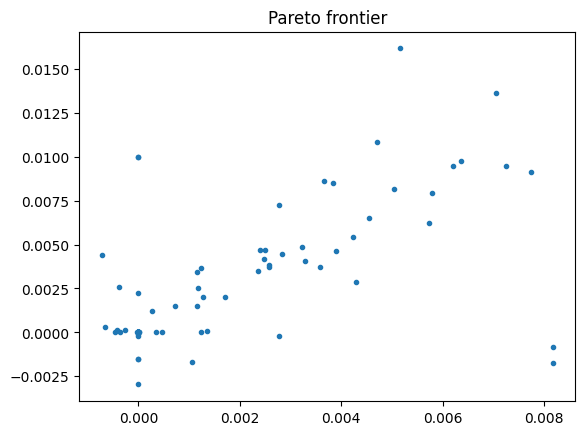

In [7]:
#plt.plot(tsr_f1_arvot[40:61], tsr_f2_arvot[40:61], marker='.', linestyle='-',color='red')
#plt.plot(r_f1_arvot[40:61], r_f2_arvot[40:61], marker='.', linestyle='-',color='blue')
plt.plot(diff_f1, diff_f2, marker='.', linestyle='None')
plt.title("Pareto frontier")
plt.show()
#plt.savefig('image.png')

In [8]:
for i in range(101):
    if diff_f1[i]<0 and diff_f2[i]<0:
        print(f"f1: {diff_f1[i]} f2: {diff_f2[i]}")

f1: -3.428413372162076e-16 f2: -4.433701169214528e-15
f1: -2.016713748330633e-17 f2: -3.4105393609342523e-16
f1: -4.033427496661266e-17 f2: -3.4105393609342523e-16
f1: -4.033427496661266e-17 f2: -0.00010183065663525412
f1: -5.646798495325773e-16 f2: -6.821078721868505e-16
f1: -8.066854993322532e-17 f2: -3.4105393609342523e-16
f1: -3.2267419973290127e-16 f2: -0.0002295229900131647
f1: -8.066854993322532e-17 f2: -1.7052696804671262e-16
f1: -8.066854993322532e-17 f2: -0.0015067074424708114


In [9]:
sum(diff_f2)/len(diff_f1)

0.002215451873927565